In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [21]:
data=pd.read_csv(r"c:\Users\ygala\OneDrive\Desktop\machine\project\horse survival\horse.csv")
df=pd.DataFrame(data)
df=pd.get_dummies(df)

df = df.replace({True: 1, False: 0})

df=df.drop(columns=["outcome_died","surgical_lesion_no","cp_data_no","nasogastric_reflux_ph"])



df=df.fillna(df.mean(),axis=0)
X=df.drop(columns=["outcome_lived","hospital_number"])
Y=df["outcome_lived"]
print(df.isna().sum())  # Check missing values per column

hospital_number                    0
rectal_temp                        0
pulse                              0
respiratory_rate                   0
packed_cell_volume                 0
                                  ..
abdomo_appearance_serosanguious    0
outcome_euthanized                 0
outcome_lived                      0
surgical_lesion_yes                0
cp_data_yes                        0
Length: 66, dtype: int64


C:\Users\ygala\AppData\Local\Temp\ipykernel_3596\3066069718.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


In [22]:
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled = scaler.fit_transform(X)


x_train,x_test,y_train,y_test=train_test_split(x_scaled,Y,test_size=0.2)


In [23]:
print(f"x_trian shape = {x_train.shape}\nx_test shape = {x_test.shape}\ny_train shape = {y_train.shape}\ny_test shape ={y_test.shape}")


x_trian shape = (239, 64)
x_test shape = (60, 64)
y_train shape = (239,)
y_test shape =(60,)


In [24]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, PRINT=False, gradient_type='batch', alpha=0.1):
        """
        Parameters:
        - learning_rate: hyperparmeter (0.01 | 0.001 | 0.1)
        - num_iterations: the number of loops for optimizer
        - PRINT: boolean to print the progress
        - gradient_type: string to choose the gradient descent type (batch/stochastic)
        - alpha: Regularization strength (λ in ridge regression)
                Set alpha=0 for no regularization
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.PRINT = PRINT
        self.gradient_type = gradient_type
        self.alpha = alpha 
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def initialize_parameters(self, features_num):   # Xavier initialization
        self.weights = np.random.randn(features_num,1) * np.sqrt(1/features_num)  
        self.bias = 0
        
    def sigmoid(self, z):# activation function
        return 1/(1+np.exp(-z))
    
    def linear(self, X): # compute the linear part
        return np.dot(X, self.weights) + self.bias
    
    def compute_cost(self, X, y, epsilon=1e-15):        # epsilon to prevent log errors
        m = X.shape[0]  # number of training examples
        
        predictions = self.sigmoid(self.linear(X))
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        # loss normal
        cross_entropy = (-1/m) * np.sum(y * np.log(predictions) + (1-y) * np.log(1-predictions))
        
        # Ridge regularization term (L2 penalty)
        regularization = (self.alpha/(2*m)) * np.sum(self.weights**2)
        
        return cross_entropy + regularization
        
    def BGD(self, X, y):
        
        m = X.shape[0]
        
        for i in range(self.num_iterations):
            #forward pass
            A = self.sigmoid(self.linear(X))
            
            #back pass
            dZ = A - y
            dW = (1/m) * np.dot(X.T, dZ) + (self.alpha/m) * self.weights
            db = (1/m) * np.sum(dZ)
            
            #update weights
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db
            
            #track progress
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)      
            
            if self.PRINT and i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost}")
            
    def SGD(self, X, y):
        m = X.shape[0]
        for i in range(self.num_iterations):
            for j in range(m):
                #choose the sample
                xi = X[j:j+1]
                yi = y[j:j+1]
                
                #forward pass
                a = self.sigmoid(self.linear(xi))
                
                #back pass
                dz = a - yi
                dw = np.dot(xi.T, dz) + (self.alpha/m) * self.weights
                db = np.sum(dz)
                
                #update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            #calculate performance
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)
            
            if self.PRINT and i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost}")
    
    def fit(self, X, y):
        #ensure there is no dimensional errors
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        m, n = X.shape
        
        #generate w,b
        self.initialize_parameters(n)
        
        #use  the provided  gradient type
        if self.gradient_type == 'batch':
            self.BGD(X, y)
        elif self.gradient_type == 'stochastic':
            self.SGD(X, y)
            
    def predict(self, X, threshold=0.5):
        # classify according to a threshold
        z = self.linear(X)
        output = self.sigmoid(z)
        return (output >= threshold).astype(int)
    

In [25]:
# Convert y_test to numpy array and ensure it's 1D
y_test = np.array(y_test).flatten()

# Create and train models
models = {
    "Batch (no reg)": LogisticRegression(PRINT= True, gradient_type='batch', alpha=0),
    "Stochastic (no reg)": LogisticRegression(PRINT = True ,gradient_type='stochastic', alpha=0),
    "Batch (L2 reg)": LogisticRegression(PRINT = True, gradient_type='batch', alpha=0.1),
    "Stochastic (L2 reg)": LogisticRegression(PRINT = True, gradient_type='stochastic', alpha=0.1)
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(x_train, y_train)

Training Batch (no reg)...
Iteration 0: Cost = 0.7473082012007668
Iteration 100: Cost = 0.5050067487820339
Iteration 200: Cost = 0.4381867109223641
Iteration 300: Cost = 0.40050118154035896
Iteration 400: Cost = 0.37448103321511844
Iteration 500: Cost = 0.355027613031185
Iteration 600: Cost = 0.3397737791878346
Iteration 700: Cost = 0.3273917445874847
Iteration 800: Cost = 0.3170685122234854
Iteration 900: Cost = 0.3082778090399779
Training Stochastic (no reg)...
Iteration 0: Cost = 0.42052215103009877
Iteration 100: Cost = 0.15676910067607158
Iteration 200: Cost = 0.14161930085295707
Iteration 300: Cost = 0.1338325910031984
Iteration 400: Cost = 0.1286130301615807
Iteration 500: Cost = 0.1246983079296426
Iteration 600: Cost = 0.1215751201875158
Iteration 700: Cost = 0.11898401426350988
Iteration 800: Cost = 0.11677559972713915
Iteration 900: Cost = 0.11485598983737719
Training Batch (L2 reg)...
Iteration 0: Cost = 0.8576382879997486
Iteration 100: Cost = 0.5537738377536585
Iteration 2

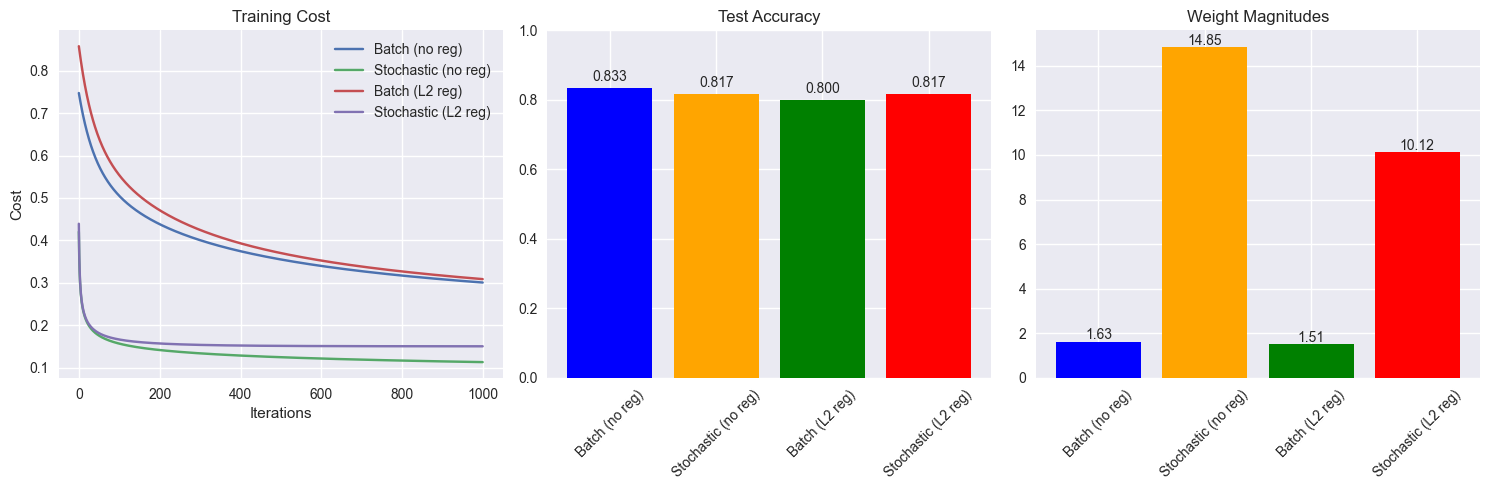

In [26]:
plt.figure(figsize=(15, 5))

# 1. Training Curves
plt.subplot(1, 3, 1)
for name, model in models.items():
    plt.plot(model.cost_history, label=name)
plt.title("Training Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)

# 2. Test Accuracy
plt.subplot(1, 3, 2)
accuracies = []
for name, model in models.items():
    y_pred = model.predict(x_test).flatten()  # Ensure predictions are 1D
    acc = np.mean(y_test == y_pred)
    accuracies.append(acc)
    
plt.bar(models.keys(), accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title("Test Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.02, f"{acc:.3f}", ha='center')

# 3. Weight Magnitudes
plt.subplot(1, 3, 3)
norms = [np.linalg.norm(model.weights) for model in models.values()]
plt.bar(models.keys(), norms, color=['blue', 'orange', 'green', 'red'])
plt.title("Weight Magnitudes")
plt.xticks(rotation=45)
for i, norm in enumerate(norms):
    plt.text(i, norm+0.1, f"{norm:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [27]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge.fit(x_train, y_train)

# Make predictions
y_pred = ridge.predict(x_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Coefficients: {ridge.coef_}")
print(f"Intercept: {ridge.intercept_}")

Mean Squared Error: 0.1267
Coefficients: [ 0.03905591 -0.03209441  0.03260219 -0.10968538  0.10655608 -0.05580459
  0.00575277  0.0250005  -0.00701507  0.00543782 -0.00543782  0.01436493
 -0.01436493 -0.00834456 -0.04797747  0.01100651 -0.00114962  0.00857297
  0.00877933  0.0202753   0.05222377 -0.0613267  -0.10914055 -0.02090845
 -0.05590013 -0.0162213  -0.05794179  0.00260061  0.04289495  0.06215638
 -0.01963097 -0.02131262 -0.08252283  0.01237502 -0.08195943 -0.00062685
  0.03494362  0.03070358  0.06390585 -0.01456226  0.04280173  0.02482679
 -0.01339128 -0.03781394  0.01789423  0.02544812  0.0215693   0.04559084
  0.03989882 -0.02675118 -0.01247285  0.00479024 -0.006617   -0.01631149
  0.03299328  0.02058939 -0.02136778  0.03246187 -0.01036934  0.0037789
 -0.03664551 -0.25348744 -0.05844441  0.0402981 ]
Intercept: 0.5898703697593406


In [28]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import log_loss
model_BGD=LogisticRegression(solver='lbfgs',
                             max_iter=10000,
                             penalty='l2'
                             )

model_SGD=SGDClassifier(max_iter=10000,
                         loss='log_loss',
                        alpha=0.001,              
                        learning_rate='adaptive',
                        eta0=0.01,
                        penalty='l2')


In [29]:
model_BGD.fit(x_train, y_train)
y_pred_batch_proba = model_BGD.predict_proba(x_test)[:, 1]  # Class 1 probabilities
loss_BGD = log_loss(y_test, y_pred_batch_proba)
print(f"Log Loss of Batch Gradient Descent: {loss_BGD:.4f}")

# Stochastic Gradient Descent (SGD)
model_SGD.fit(x_train, y_train)
y_pred_SGD_proba = model_SGD.predict_proba(x_test)[:, 1]    # Class 1 probabilities
loss_SGD = log_loss(y_test, y_pred_SGD_proba)
print(f"Log Loss of Stochastic Gradient Descent: {loss_SGD:.4f}")





Log Loss of Batch Gradient Descent: 0.3740
Log Loss of Stochastic Gradient Descent: 0.3667


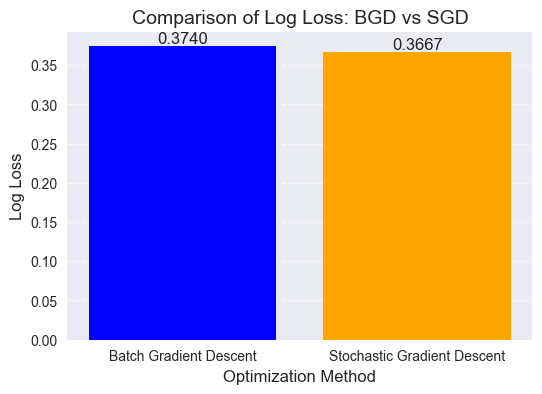

In [30]:
plt.style.use('seaborn-v0_8')

# Log loss values from your models
loss_values = [loss_BGD, loss_SGD]
models = ['Batch Gradient Descent', 'Stochastic Gradient Descent']

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, loss_values, color=['blue', 'orange'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Comparison of Log Loss: BGD vs SGD', fontsize=14)
plt.xlabel('Optimization Method', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()